In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
import os
import mlflow
import mlflow.tensorflow
import mlflow.pytorch


In [5]:

mlflow.set_experiment("Flower_Classification_Experiment")

<Experiment: artifact_location='file:///d:/2025/computer_vision/classification/mlruns/810296060030717373', creation_time=1748962721630, experiment_id='810296060030717373', last_update_time=1748962721630, lifecycle_stage='active', name='Flower_Classification_Experiment', tags={}>

In [6]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
# Define the data directory
data_dir = 'dataset'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
#image_datasets

In [8]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 2746, 'val': 740}


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [19]:
# Define hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 4

# Load the pre-trained ResNet-18 model
model = models.resnet18(weights=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define hyperparameters
learning_rate = 0.001
num_epochs = 5
batch_size = 1
num_classes = 5  # <-- Set this according to your dataset

# Load the pre-trained EfficientNet-B4 model
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Replace the classifier to match your number of classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Freeze all layers except the classifier
for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define optimizer and loss function
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\ankan/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:03<00:00, 6.66MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define hyperparameters
learning_rate = 0.001
num_epochs = 5
batch_size = 1
num_classes = 5  # Set this according to your dataset

# Load the pre-trained EfficientNet-B0 model
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Replace the classifier to match your number of classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Freeze all layers except the classifier
for name, param in model.named_parameters():
    param.requires_grad = "classifier" in name

# Define optimizer and loss function
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Move model to GPU/CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [27]:
with mlflow.start_run():
    # Log model and training parameters
    mlflow.log_param("model_name", "efficientnet_b0")
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("criterion", "CrossEntropyLoss")
    mlflow.log_param("data_augmentation", True)
    mlflow.log_param("device", device.type)
    mlflow.log_param("dataset_size", dataset_sizes['train'])
    mlflow.log_param("num_classes", len(class_names))
    mlflow.log_param("class_names", ", ".join(class_names))

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Log metrics per phase and epoch
            mlflow.log_metric(f"{phase}_loss", epoch_loss, step=epoch)
            mlflow.log_metric(f"{phase}_accuracy", epoch_acc.item(), step=epoch)

    # Log final model once at the end
    mlflow.pytorch.log_model(model, "model")

print("Training complete!")


Epoch 1/5
--------------------
train Loss: 0.9372 Acc: 0.6479
val Loss: 0.4784 Acc: 0.8716
Epoch 2/5
--------------------
train Loss: 0.7715 Acc: 0.7229
val Loss: 0.4434 Acc: 0.8608
Epoch 3/5
--------------------
train Loss: 0.7332 Acc: 0.7302
val Loss: 0.3732 Acc: 0.8811
Epoch 4/5
--------------------
train Loss: 0.7298 Acc: 0.7294
val Loss: 0.3523 Acc: 0.8932
Epoch 5/5
--------------------
train Loss: 0.7149 Acc: 0.7418
val Loss: 0.3672 Acc: 0.8811


2025/06/03 23:33:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training complete!


In [7]:
# Save the model
torch.save(model.state_dict(), 'flower_classification_model.pth')

In [8]:
#Classification on Unseen Image
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('flower_classification_model.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

In [13]:
# Load and preprocess the unseen image
image_path = r'D:\2025\computer_vision\classification\dataset\test\Image_3.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [14]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: dandelion


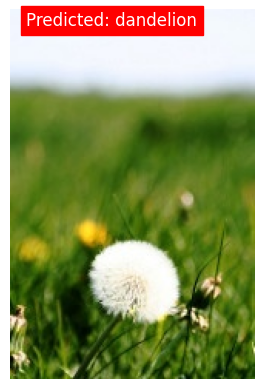

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()